# Homework: Build Your Own Segmentation Model with ConvNeXt

In this assignment, you will build an image segmentation model that uses a provided ConvNeXt layer as the backbone (encoder). Your challenge is to design and implement the segmentation head (decoder) in any way you prefer. This task gives you the flexibility to experiment with different architectural ideas while learning how to repurpose modern convolutional blocks for dense prediction tasks.

## Overview

- **Task:**  
  Use the provided ConvNeXt layer to extract features from the input images, then design your own segmentation decoder to output pixel-wise predictions (segmentation masks).

- **Dataset:**  
  We'll use the Oxford-IIIT Pet dataset (which contains images along with pixel-level segmentation masks). This dataset is easy to download via PyTorch's `torchvision` library.

- **Goal:**  
  Design a segmentation model that can accurately separate the pet from the background (or other semantic regions) in the images. Experiment with different decoder architectures, upsampling techniques, and loss functions.

## Provided ConvNeXt Layer

Below is a simplified ConvNeXt layer that you will use as the building block of your encoder. Feel free to experiment with it or use it as is:

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNeXtLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, padding=3):
        super(ConvNeXtLayer, self).__init__()
        # Depthwise Convolution
        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                stride=stride, padding=padding, groups=in_channels)
        # Layer Normalization (applied over channels)
        self.norm = nn.LayerNorm([in_channels, 1, 1])
        # Activation
        self.activation = nn.GELU()
        # Pointwise Convolution
        self.pwconv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.dwconv(x)
        # Since nn.LayerNorm expects the normalized shape to match the last dimensions,
        # we use a permutation to apply it over channels.
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C]
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)  # [B, C, H, W]
        x = self.activation(x)
        x = self.pwconv(x)
        return x


## Your Tasks

### 1. Data Exploration and Preprocessing

- **Download the Dataset:**  
  Use PyTorch's `torchvision.datasets.OxfordIIITPet` to download the dataset with segmentation masks.
  
- **Visualize the Data:**  
  Explore the images and segmentation masks to understand the data distribution and check for any class imbalances.

#### Example Code to Download & Visualize:


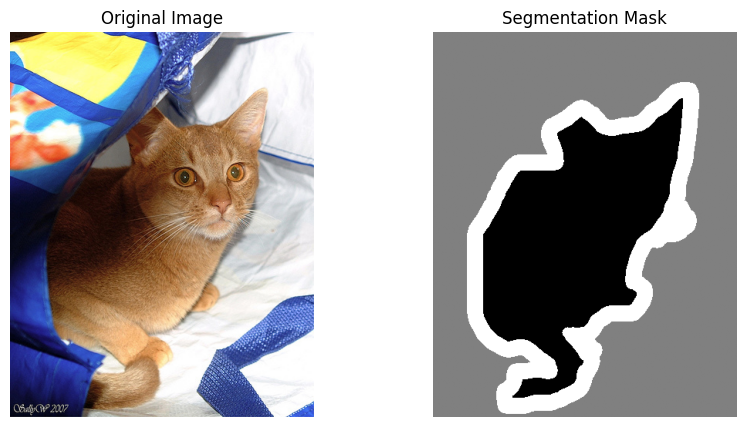

In [4]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a transform to convert images to tensors
transform = transforms.ToTensor()

# Download the Oxford-IIIT Pet dataset with segmentation masks
dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform
)

# Visualize a sample image and its segmentation mask
image, mask = dataset[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.show()


### 2. Model Design and Implementation

Your challenge here is to design the **segmentation decoder** that complements the provided ConvNeXtLayer-based encoder. The key idea is to take the lower-resolution feature maps produced by the encoder and transform them into full-resolution segmentation maps.

#### What You Need to Achieve

- **Input:**  
  The encoder (which you will build by stacking one or more `ConvNeXtLayer`s) takes an image of shape `[B, 3, H, W]` and outputs a feature map. For example, after two layers you might have features of shape `[B, 128, H_enc, W_enc]` where `H_enc` and `W_enc` are downsampled versions of `H` and `W`.

- **Output:**  
  Your segmentation decoder must transform the encoder output into a segmentation mask with shape `[B, num_classes, H, W]`, where `num_classes` is the number of segmentation labels (e.g., 2 for binary segmentation like pet vs. background).

#### Hints for Building Your Decoder

1. **Upsampling:**  
   - **Transposed Convolutions:**  
     You can use layers like `nn.ConvTranspose2d` to upsample the feature maps gradually.
   - **Interpolation + Convolution:**  
     Another approach is to upsample using `F.interpolate` (e.g., bilinear interpolation) and follow up with a convolution layer (`nn.Conv2d`) to refine the features.

2. **Skip Connections:**  
   - To help recover spatial details lost during downsampling, consider adding skip connections from early encoder layers to corresponding decoder layers.

3. **Layer Organization:**  
   - Organize your decoder in stages. For example:
     - **Stage 1:** Upsample features (e.g., from `[B, 128, H_enc, W_enc]` to `[B, 64, H_enc*2, W_enc*2]`).
     - **Stage 2:** Further process and upsample until you reach the original resolution `[B, num_classes, H, W]`.

#### Pseudo-Code Example (Skeleton)

Below is a pseudo-code outline to guide you. **Note:** Do not use this code verbatim—use it as a reference to design your own decoder.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        # Build your encoder using the provided ConvNeXtLayer(s)
        # Example (you can customize this part):
        # self.encoder = nn.Sequential(
        #     ConvNeXtLayer(in_channels=3, out_channels=64),
        #     ConvNeXtLayer(in_channels=64, out_channels=128)
        # )
        
        # YOUR TASK: Design the decoder
        # Hints:
        # - Your decoder should accept the encoder's output (e.g., [B, 128, H_enc, W_enc])
        # - Use transposed convolutions or F.interpolate + convolution layers to upsample.
        # - Aim to reach an output shape of [B, num_classes, H, W].
        # - Consider using skip connections for better spatial detail.
        #
        # Example skeleton (not a full solution):
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample stage 1
        #     nn.ReLU(inplace=True),
        #     # Add more layers or skip connections as needed
        #     nn.Conv2d(64, num_classes, kernel_size=1)  # Final output layer
        # )

    def forward(self, x):
        # x: [B, 3, H, W]
        features = self.encoder(x)  # e.g., [B, 128, H_enc, W_enc]
        out = self.decoder(features)  # Your decoder should produce [B, num_classes, H, W]
        
        # If necessary, use interpolation to ensure the output size matches the input size
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out


### 3. Training and Evaluation

In this section, you'll set up your training loop, choose appropriate metrics, and evaluate your segmentation model. We'll use:

- **Loss Function:** `CrossEntropyLoss` (suitable for multi-class segmentation).
- **Metrics:**
  - **Pixel Accuracy:** The percentage of correctly predicted pixels.
  - **Intersection-over-Union (IoU):** The ratio of the intersection to the union of the predicted and ground truth regions for each class.

#### Metric Functions

Add these helper functions to compute Pixel Accuracy and Mean IoU:

```python
import torch

def pixel_accuracy(output, target):
    """
    Computes pixel accuracy.
    
    Parameters:
      output (torch.Tensor): Model predictions of shape [B, num_classes, H, W].
      target (torch.Tensor): Ground truth labels of shape [B, H, W].
    
    Returns:
      float: Pixel accuracy.
    """
    with torch.no_grad():
        # Get predicted classes from output
        pred = output.argmax(dim=1)
        correct = (pred == target).float()
        acc = correct.sum() / correct.numel()
    return acc

def intersection_over_union(output, target, num_classes):
    """
    Computes Mean Intersection-over-Union (IoU) over all classes.
    
    Parameters:
      output (torch.Tensor): Model predictions of shape [B, num_classes, H, W].
      target (torch.Tensor): Ground truth labels of shape [B, H, W].
      num_classes (int): Number of segmentation classes.
    
    Returns:
      float: Mean IoU over all classes.
    """
    with torch.no_grad():
        pred = output.argmax(dim=1)
        ious = []
        for cls in range(num_classes):
            pred_inds = (pred == cls)
            target_inds = (target == cls)
            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            if union == 0:
                ious.append(torch.tensor(1.0))  # If no ground truth for class, count IoU as 1.
            else:
                ious.append(intersection / union)
        mean_iou = torch.mean(torch.stack(ious))
    return mean_iou


# Training Loop Example
Below is an example training loop that uses the above metrics. This loop trains your model for a set number of epochs, prints the loss for each epoch, and evaluates the Pixel Accuracy and Mean IoU after each epoch.

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Assume `dataset` is already defined (using the Oxford-IIIT Pet dataset)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5  # Adjust as needed
num_classes = 2  # Change if you have more than two classes

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        optimizer.zero_grad()

        # Forward pass: Predict segmentation masks
        outputs = model(images)
        # Ensure masks are of shape [B, H, W] and type long
        loss = criterion(outputs, masks.squeeze(1).long())

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate the model on the training data (or validation data if available)
    model.eval()
    acc_total, iou_total, count = 0.0, 0.0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            outputs = model(images)
            # Compute Pixel Accuracy and Mean IoU
            acc = pixel_accuracy(outputs, masks.squeeze(1).long())
            iou = intersection_over_union(outputs, masks.squeeze(1).long(), num_classes)
            acc_total += acc.item()
            iou_total += iou.item()
            count += 1

    avg_acc = acc_total / count
    avg_iou = iou_total / count
    print(f"Epoch [{epoch+1}/{num_epochs}], Pixel Accuracy: {avg_acc:.4f}, Mean IoU: {avg_iou:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'segmentation_model.pth')


## Deliverables

Please ensure that your final submission includes **all the components in a single Jupyter Notebook**. Your notebook should be well-organized, with clear headings, comments, and markdown cells that explain your work. Specifically, your submission should include:

1. **Data Exploration and Preprocessing**
   - Code to download and load the Oxford-IIIT Pet dataset.
   - Visualizations of sample images and their corresponding segmentation masks.
   - A brief analysis discussing any observations from the data (e.g., class imbalances, noise, etc.).

2. **Model Design and Implementation**
   - Your implementation of an encoder that uses the provided `ConvNeXtLayer`.
   - Your custom segmentation decoder design. Be sure to clearly explain:
     - The input and output shapes (e.g., encoder output of shape `[B, 128, H_enc, W_enc]` and desired decoder output of `[B, num_classes, H, W]`).
     - The architectural choices (e.g., upsampling methods, any skip connections, etc.).
     - How your design transforms low-resolution feature maps back to full-resolution segmentation maps.

3. **Training and Evaluation**
   - A complete training loop with:
     - The use of `CrossEntropyLoss` as your loss function.
     - An optimizer (e.g., Adam) and any learning rate adjustments.
   - Code to compute evaluation metrics:
     - **Pixel Accuracy**: The percentage of correctly predicted pixels.
     - **Intersection-over-Union (IoU)**: Mean IoU across classes.
   - Visualizations or printed outputs that demonstrate model performance over epochs.
   - A brief discussion of the results (e.g., trends in loss, pixel accuracy, and IoU).

4. **Overall Notebook Structure**
   - Clear organization with sections separated by markdown headings.
   - Inline comments explaining key parts of your code.
   - A summary or conclusion section reflecting on your experiments and results.

---

### Submission Instructions

- **Format:** Submit your work as a single Jupyter Notebook (e.g., `segmentation_homework.ipynb`).
- **Content:** The notebook must include all the code, visualizations, and explanations outlined above.
